# Projet commencé le 04/02/2019

## Imports :

In [118]:
import numpy as np
import pandas as pd
from __future__ import division
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from io import BytesIO
import requests
import bq_helper
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras_rcnn as KC
import keras
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Convolution2D, Flatten, MaxPooling2D, Dropout, Activation, Reshape, Input
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import decode_predictions, VGG16
import tensorflow as tf
import queue as Q
import math
import random
import os

# DEFINITION DES FONCTIONS

In [119]:
# Return une image depuis son URL
def images_from_url(url):
    try:
        response = requests.get(url)
        return Image.open(BytesIO(response.content))
    except:
        return False

In [120]:
# Permet d'afficher (pour une image, une liste de bboxs et une liste de labels) une image avec les objets labellisés
def plot_bbox_label(image, bbox, label):
    im_dim_y = image.shape[0]
    im_dim_x = image.shape[1]
    
    fig, ax = plt.subplots(1,figsize=(15,20))
    ax.imshow(image)
    
    it = 0
    for l_bbox in bbox:
        im_width = l_bbox[2] - l_bbox[0]
        im_height = l_bbox[3] - l_bbox[1]
        
        np.random.seed(seed = int(np.prod(bytearray(label[it], 'utf8'))) %2**32)
        color = np.random.rand(3,1)
        color = np.insert(color, 3, 0.7)
        
        ax.add_patch(patches.Rectangle((l_bbox[0]*im_dim_x, l_bbox[1]*im_dim_y), im_width*im_dim_x, im_height*im_dim_y, linewidth=8, edgecolor=color, facecolor='none'));
        text = ax.annotate(label[it], (l_bbox[2]*im_dim_x,l_bbox[1]*im_dim_y), bbox=dict(boxstyle="square,pad=0.3", fc=color, lw=2))
        text.set_fontsize(18)
        it = it+1
    plt.show()

In [121]:
# Calcul l'IoU pour 2 box au format xmin ymin xmax ymax
def IoU(bbox1, bbox2):
    w_intersect = (bbox1[2] - bbox1[0]) + (bbox2[2] - bbox2[0]) - (max(bbox1[2], bbox2[2]) - min(bbox1[0], bbox2[0]))
    h_intersect = (bbox1[3] - bbox1[1]) + (bbox2[3] - bbox2[1]) - (max(bbox1[3], bbox2[3]) - min(bbox1[1], bbox2[1]))
    
    if(w_intersect < 0 or h_intersect < 0):
        return 0
    
    intersect = w_intersect * h_intersect

    union_1 = (bbox1[2]-bbox1[0]) * (bbox1[3]-bbox1[1])
    union_2 = (bbox2[2]-bbox2[0]) * (bbox2[3]-bbox2[1])
    
    union = union_1 + union_2 - intersect

    return intersect/union

In [122]:
# Créer des anchors avec le centre (x,y) et la largeur/hauteur de la convolution (de réduction 16)
def generate_anchors(center_x, center_y, conv_w, conv_h):
    anchor_ratio = [[1, 1], [1, 2], [2, 1]]
    anchor_coef = [1, 2, 4]
    anchor_size = 128
    
    anchor_list = []
    
    for ratio in anchor_ratio:
        for coef in anchor_coef:
            anchor_width = (anchor_size*coef*ratio[0]) / (conv_w*16)
            anchor_height = (anchor_size*coef*ratio[1]) / (conv_h*16)
            anchor_x = (center_x/conv_w) - (anchor_width/2)
            anchor_y = (center_y/conv_h) - (anchor_height/2)
            anchor = [anchor_x, anchor_y, anchor_x+anchor_width, anchor_y+anchor_height]
            
            anchor_list.append(anchor)
    
    anchor_list = np.array(anchor_list)
    
    return anchor_list

In [123]:
# Opération de RoI pooling sur un tableau et une taille de shape*shape
# Il y a 3 lignes similaire en fonction du type d'opération utilisé pour le pooling (apres test la moyenne est mieu que le max)
def RoI(array, shape):
    result = np.zeros((shape, shape, array.shape[2]))
    for i in range (0, shape):
        for j in range (0, shape):
            sub_array = array[int(i*array.shape[0]/shape):int((i+1)*array.shape[0]/shape), int(j*array.shape[1]/shape):int((j+1)*array.shape[1]/shape)]
            #result[i][j] = np.amax(np.amax(sub_array, axis = 0), axis = 0)
            result[i][j] = np.mean(np.mean(sub_array, axis = 0), axis = 0)
            #result[i][j] = np.amin(np.amin(sub_array, axis = 0), axis = 0)
    return result

In [124]:
# Extrait la partie convolution de VGG16
def generate_conv():
    vgg16_net = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
    model = Model(input=vgg16_net.layers[0].input, output=vgg16_net.layers[17].output)
    return model

In [125]:
# Une accuracy custom, elle est légérement capable de dépasser 1 mais sinon avec keras,
# Pour une loss custom, l'accuracy est bugé (c'est un bug connu)
def acc(y_true, y_pred): return K.mean(K.round(y_pred)*y_true + (1.-K.round(y_pred))*(1.-y_true))

In [126]:
# Loss custom pour le classifier du rpn, on igniore les cas ou la prédiction est (0, 0) et on renforce l'apprentissage lors de la présence d'un objet
def custom_loss_rpn_cls(y_true, y_pred):
    shape = K.shape(y_true)
    depth = shape[0]
        
    # Retire les [0, 0] (c'est à dire entre objet et pas d'objet)
    new_y_pred = K.zeros((depth, 2))
    for i in range (0, 9):
        cond = K.equal(y_true[:, 2*i:2*i+2], [0,0])
        cond = tf.math.logical_and(cond[:,0], cond[:,1])
        cond = K.concatenate([cond, cond])
        cond = K.reshape(cond, (depth,2))
        
        temp = K.switch(cond, y_true[:, 2*i:2*i+2], y_pred[:, 2*i:2*i+2])
        if i == 0:
            new_y_pred = temp
        else:
            new_y_pred = K.concatenate([new_y_pred, temp])

    new_y_pred = K.reshape(new_y_pred, (depth, 18))
    cls = K.binary_crossentropy(y_true, new_y_pred)
    
    # Renforce les [1,0] (c'est à dire la présence d'objet)
    new_cls = K.zeros((depth, 2))
    for i in range (0, 9):
        cond = K.equal(y_true[:, 2*i:2*i+2], [0,1])
        cond = tf.math.logical_and(cond[:,0], cond[:,1])
        cond = K.concatenate([cond, cond])
        cond = K.reshape(cond, (depth,2))
        
        temp = K.switch(cond, cls[:, 2*i:2*i+2], cls[:, 2*i:2*i+2]*4.7)
        if i == 0:
            new_cls = temp
        else:
            new_cls = K.concatenate([new_cls, temp])
    new_cls = K.reshape(new_cls, (depth, 18))
    
    # On re multipli pour compenser les [0,0]
    # Les coeficients ont était trouvé expérimentalement
    return K.mean(new_cls*2.1)

In [127]:
# Fonction smoothL1 (fonction connue)
def smoothL1(y_true, y_pred):
    x   = K.abs(y_true - y_pred)
    x   = K.switch(x < 1, x*x, x)
    return  x

In [128]:
# Loss custom pour le regresseur du rpn, on igniore les cas ou la prédiction est (0, 0)
def custom_loss_rpn_reg(y_true, y_pred):
    shape = K.shape(y_true)
    depth = shape[0]
        
    # Retire les [0, 0, 0, 0] c'est à dire qu'il n'y a pas de présence d'objet
    new_y_pred = K.zeros((depth, 4))
    for i in range (0, 9):
        cond = K.equal(y_true[:, 2*i:2*i+4], [0,0,0,0])
        cond = tf.math.logical_and(tf.math.logical_and(cond[:,0], cond[:,1]), tf.math.logical_and(cond[:,2], cond[:,3]))
        cond = K.concatenate([cond, cond, cond, cond])
        cond = K.reshape(cond, (depth,4))
        
        temp = K.switch(cond, y_true[:, 2*i:2*i+4], y_pred[:, 2*i:2*i+4])
        if i == 0:
            new_y_pred = temp
        else:
            new_y_pred = K.concatenate([new_y_pred, temp])

    new_y_pred = K.reshape(new_y_pred, (depth, 36))
    reg = smoothL1(y_true, new_y_pred)
    
    # On re multipli pour compenser les [0,0,0,0]
    # Les coeficients ont était trouvé expérimentalement
    return K.mean(reg)*9

In [129]:
# Return le model utilisé pour le classifier
def generate_cls_nn():
    vgg16_net = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
    
    l_input = Input(shape=(7, 7, 512))
    l_flatten = vgg16_net.get_layer("flatten")
    l_fc1 = vgg16_net.get_layer("fc1")
    l_fc2 = vgg16_net.get_layer("fc2")
    l_output = vgg16_net.get_layer("predictions")
    model = Model(input=l_input, output=l_output(l_fc2(l_fc1(l_flatten(l_input)))))
    return model

In [130]:
# Return la convolution d'une image
def pred_conv(image):
    return conv_net.predict(np.array([image]))[0]

# DEFINITION DES GLOBALS

In [131]:
conv_net = generate_conv()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  after removing the cwd from sys.path.


In [132]:
rpn_cls_net = load_model('../input/cls.h5', custom_objects={'custom_loss_rpn_cls': custom_loss_rpn_cls})

In [133]:
rpn_reg_net = load_model('../input/reg.h5', custom_objects={'custom_loss_rpn_reg': custom_loss_rpn_reg})

In [134]:
cls_net = generate_cls_nn()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  # Remove the CWD from sys.path while we load stuff.


# PARTIE APPLICATION

In [135]:
def predict(URL, threshold_cls_rpn = 0.7, threshold_cls_vgg = 0.5, threshold_iou = 0.8):
    # L'image est téléchargé et mise au bon format (le format vgg est non normalisé, celui de notre rpn l'est car nous donne de meilleurs résultats)
    image_test = images_from_url(URL)
    if(image_test != False):
        image_test_w, image_test_h = image_test.size
        taille_max = max(image_test_w, image_test_h)
        coef = 800/taille_max
        image_test = image_test.resize((int(coef*image_test_w), int(coef*image_test_h)))
        image_test_vgg = np.array(image_test)
        image_test = np.array(image_test)/255
        if(len(image_test.shape) == 3):
            anchor_test_valid = []

            image_test_conv_vgg = pred_conv(image_test_vgg)
            image_test_conv = pred_conv(image_test)

            # On passe sur chaque pixel de la convolution
            for x in range (1, image_test_conv.shape[1] - 1):
                for y in range (1, image_test_conv.shape[0] - 1):
                    anchor_valid = False
                    anchor_empty = True

                    # On effectue une prédiction sur la fenetre glissant centré sur le pixel actuel
                    pred_cls = rpn_cls_net.predict(np.array([image_test_conv[y-1:y+2, x-1:x+2]]))[0]
                    pred_reg = rpn_reg_net.predict(np.array([image_test_conv[y-1:y+2, x-1:x+2]]))[0]

                    # On test pour toutes les anchors si le rpn à detecté un objet
                    list_anchors = generate_anchors(x, y, image_test_conv.shape[1], image_test_conv.shape[0])
                    for k in range(0, 9):
                        # Si on trouve un objet à plus de 70% de sureté
                        if(pred_cls[k*2] >= threshold_cls_rpn):
                            # On recupère les infos de l'anchor
                            anchor = list_anchors[k]
                            anchor_x, anchor_y, anchor_xm, anchor_ym = anchor
                            anchor_width = anchor_xm - anchor_x
                            anchor_height = anchor_ym - anchor_y

                            # On recupère les infos de la prédiction
                            pred_reg_x, pred_reg_y, pred_reg_w, pred_reg_h = pred_reg[k*4:k*4+4]

                            # On test si l'anchor ne sort pas de l'écrant
                            cond1 = anchor_x+(pred_reg_x*anchor_width) >= 0
                            cond2 = anchor_y+(pred_reg_y*anchor_height) >= 0
                            cond3 = anchor_x+(pred_reg_x*anchor_width) + (10**pred_reg_w)*anchor_width < 1
                            cond4 = anchor_y+(pred_reg_y*anchor_height) + (10**pred_reg_h)*anchor_height < 1
                            if(cond1 and cond2 and cond3 and cond4):
                                # On calcul le xmin/max ymin/max de la prediction relativement à l'image
                                it_min_x = int((anchor_x+(pred_reg_x*anchor_width)) * image_test_conv.shape[1])
                                it_max_x = int((anchor_x+(pred_reg_x*anchor_width) + (10**pred_reg_w)*anchor_width) * image_test_conv.shape[1])
                                it_min_y = int((anchor_y+(pred_reg_y*anchor_height)) * image_test_conv.shape[0])
                                it_max_y = int((anchor_y+(pred_reg_y*anchor_height) + (10**pred_reg_h)*anchor_height) * image_test_conv.shape[0])

                                # Si la prédiction est plus large que du 7*7 (minimum du classifier)
                                if(it_max_y-it_min_y >= 7 and it_max_x-it_min_x >= 7):
                                    # Prédiction des 5 premières classes que vgg trouve
                                    label = decode_predictions(cls_net.predict(np.array([RoI(image_test_conv_vgg[it_min_y:it_max_y, it_min_x:it_max_x], 7)])), top=5)[0]
                                    # Si la confiance accordé à la top classe de vgg est de plus de 50%
                                    if(label[0][2] >= threshold_cls_vgg):
                                        # On stock les données au plus simple pour les traiter avec le nonmax
                                        anchor_test_valid.append([label[0][2], [[label[0][1], label[1][1], label[2][1], label[3][1], label[4][1]], anchor_x+(pred_reg_x*anchor_width), anchor_y+(pred_reg_y*anchor_height), anchor_x+(pred_reg_x*anchor_width) + (10**pred_reg_w)*anchor_width, anchor_y+(pred_reg_y*anchor_height) + (10**pred_reg_h)*anchor_height]])  

            # SECTION NONMAX
            # Le but est de supprimer les overlaps au dessus d'un seuil pour les mêmes classes (il suffit d'une coresspondance dans les 5 premières classes)
            anchor_test_valid = np.array(anchor_test_valid)      
            q = Q.PriorityQueue()
            for a in anchor_test_valid:
                q.put((1-a[0] + random.random()/100000,a[1]))
            anchor_test_valid = []
            size = q.qsize()
            for i in range (0, size):
                var_i = q.get()
                found_one = False
                for a in anchor_test_valid:
                    for labelnb in range(0, 5):
                        if(IoU(a[1], var_i[1][1:5]) >= 1 - threshold_iou and a[0] == var_i[1][0][labelnb]):
                            found_one = True
                if(not found_one):
                    anchor_test_valid.append([var_i[1][0][0], var_i[1][1:5]])
            anchor_test_valid = np.array(anchor_test_valid)
            if(anchor_test_valid.shape[0] != 0):
                plot_bbox_label(image_test, anchor_test_valid[:, 1], anchor_test_valid[:, 0])
            else:
                plt.figure(figsize=(15,20))
                plt.imshow(image_test_vgg)
                plt.show()

In [136]:
def predict_multiple(list_URL):
    for URL in list_URL:
        url_pred = predict(URL)

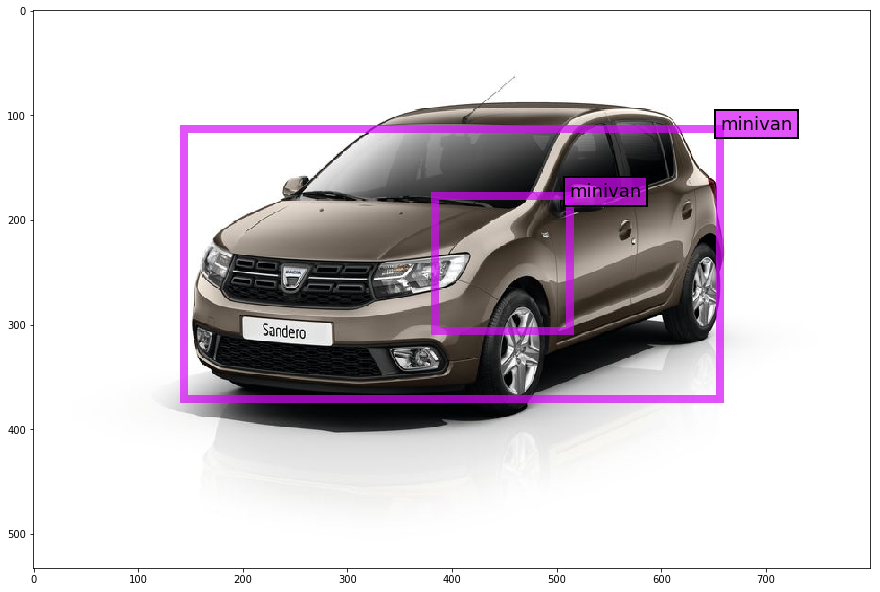

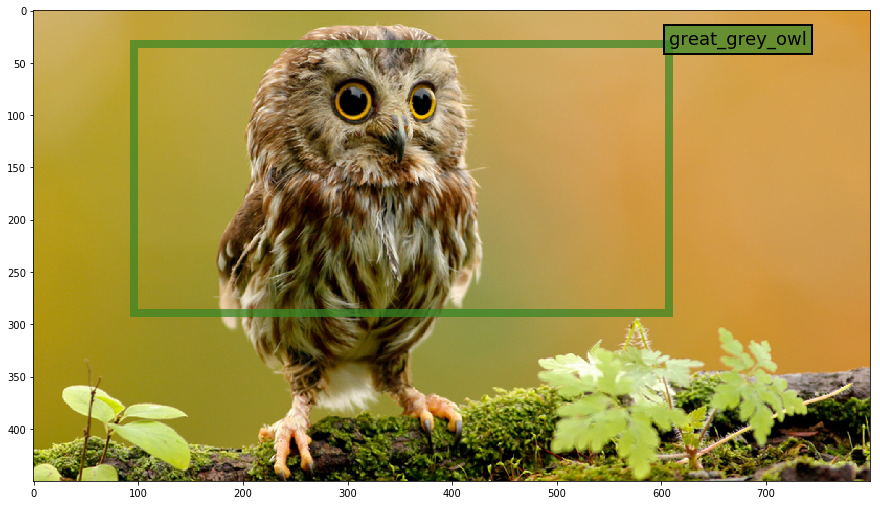

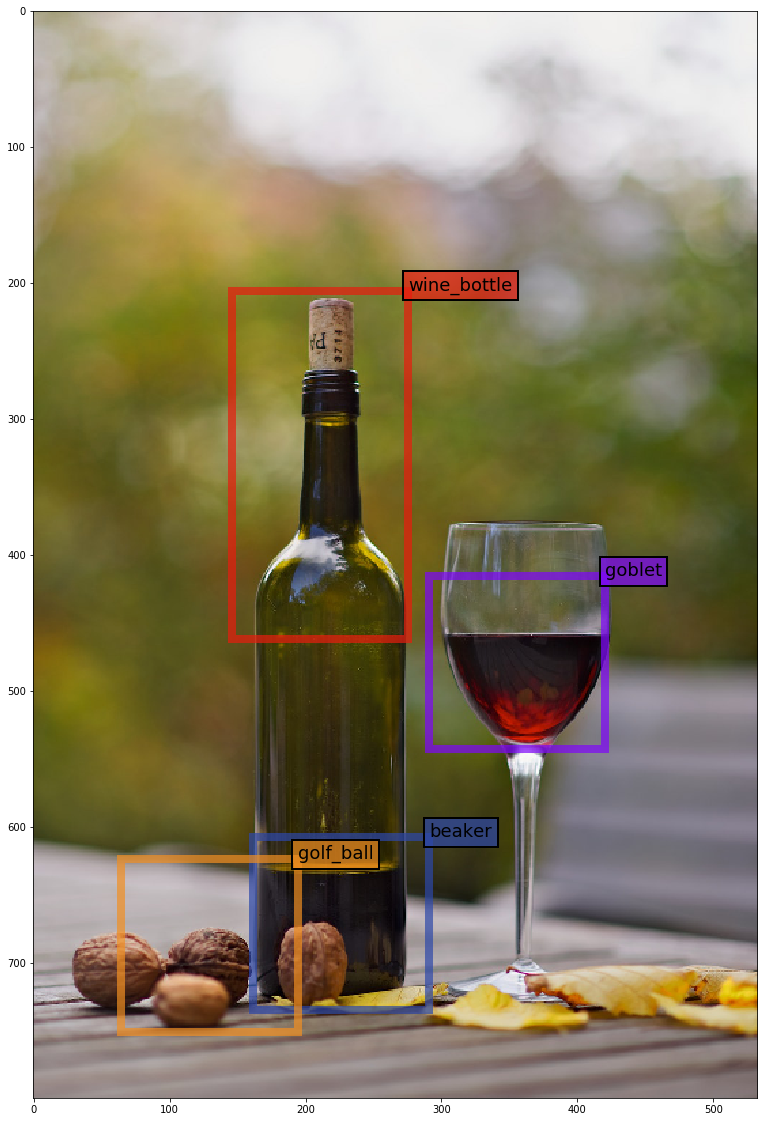

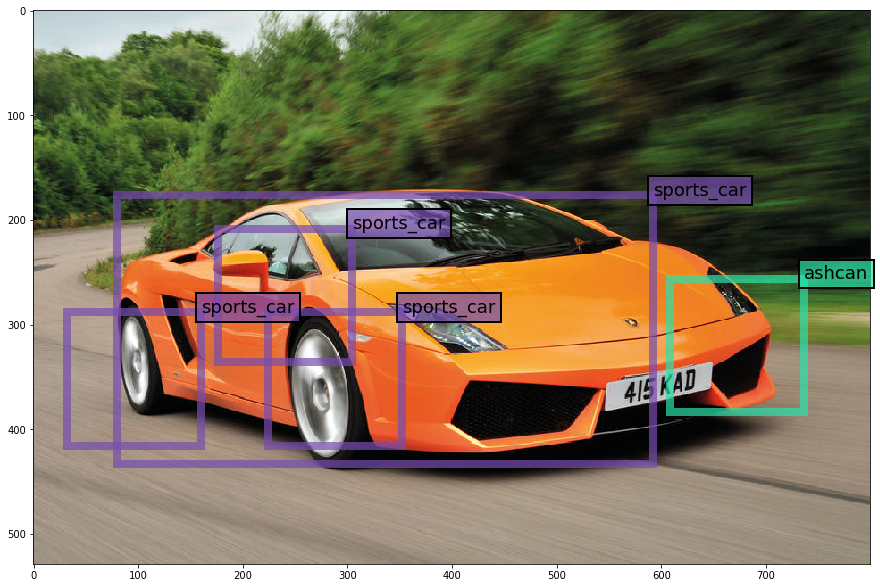

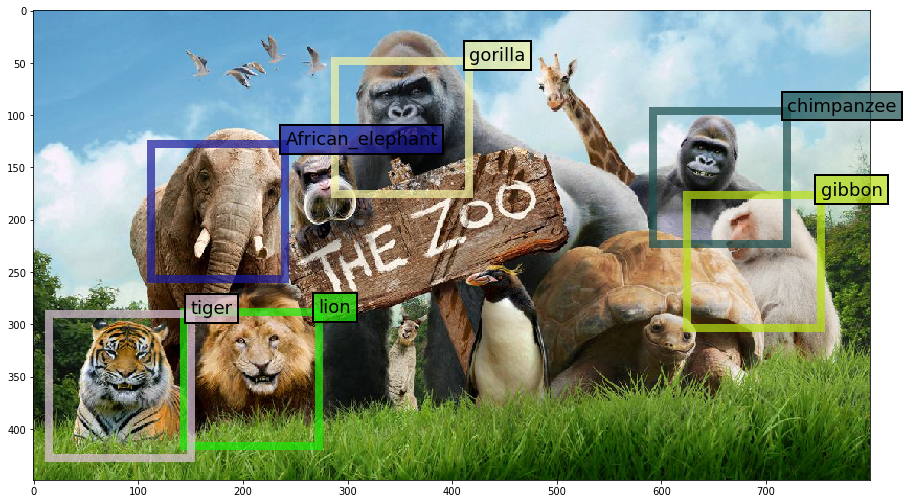

In [137]:
# UNE VOITURE :   https://www.usinenouvelle.com/mediatheque/4/5/4/000626454_image_896x598/dacia-sandero.jpg
# 2 VOITURES :   https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/s17-2051-fine-1553003760.jpg
# N VOITURES :   https://cdn-images-1.medium.com/max/1600/1*ICvAO8mPCA_sXOzW9zeM7g.jpeg
# 2 VOITURES :   https://ischool.syr.edu/infospace/wp-content/files/2015/10/toyota-and-lexus-car-on-road--e1444655872784.jpg
# ZOO : http://www.mdjunited.com/medias/images/zoo.jpg

url_images_test = ['https://www.usinenouvelle.com/mediatheque/4/5/4/000626454_image_896x598/dacia-sandero.jpg',
                   'https://images5.alphacoders.com/393/393962.jpg',
                   'https://images.unsplash.com/photo-1544776527-68e63addedf7?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80',
                   'https://www.autocar.co.uk/sites/autocar.co.uk/files/styles/gallery_slide/public/images/car-reviews/first-drives/legacy/gallardo-0638.jpg?itok=-So1NoXA', 
                   'http://www.mdjunited.com/medias/images/zoo.jpg']

predict_multiple(url_images_test)

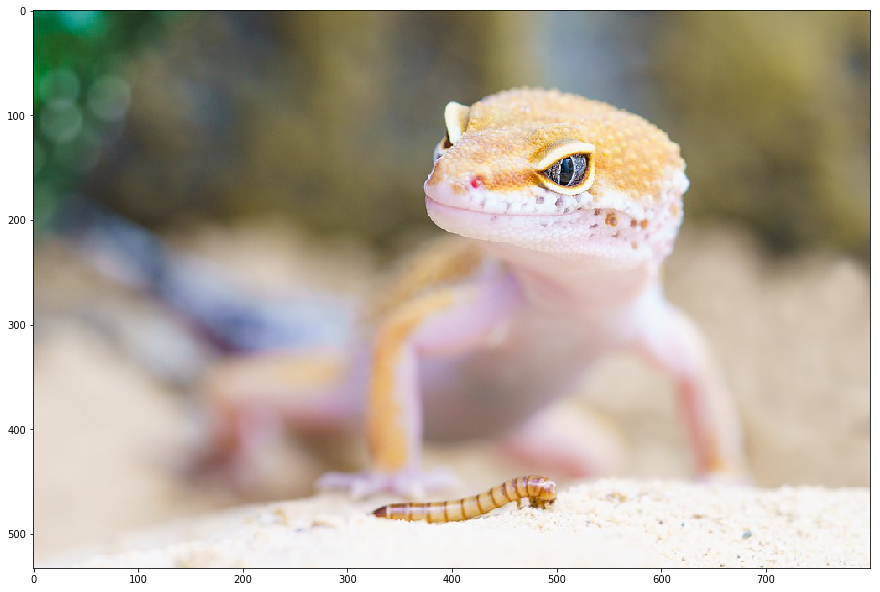

In [138]:
predict('https://cdn.pixabay.com/photo/2017/05/09/21/49/gecko-2299365_960_720.jpg', 0.7, 0.5, 0.8)

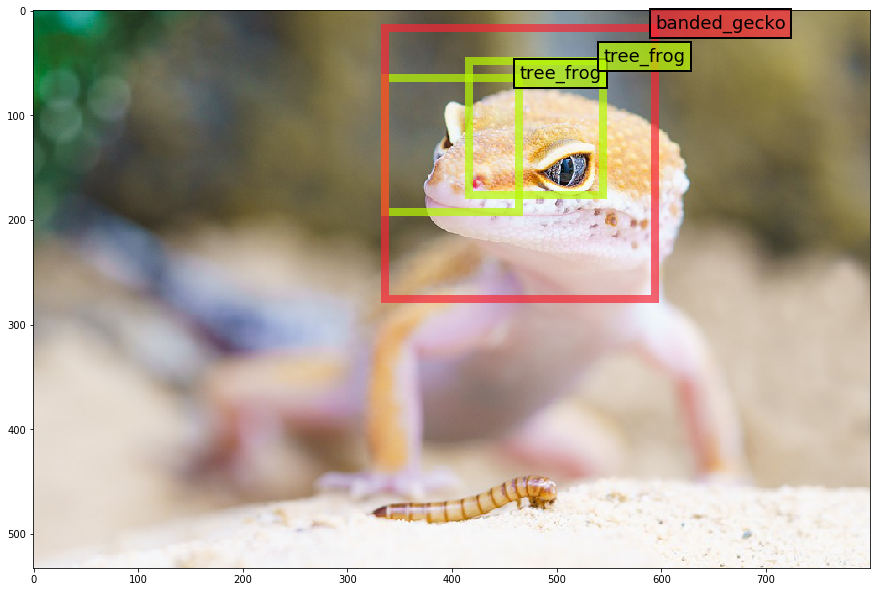

In [139]:
predict('https://cdn.pixabay.com/photo/2017/05/09/21/49/gecko-2299365_960_720.jpg', 0.7, 0.3, 0.8)